In [2]:
# !pip install py-ecg-detectors
# !pip install pandas
# !pip install numpy
# !pip install detectors
# !pip install pylab-sdk
# !pip install matplotlib
# !pip install scikit-learn
# !pip install padasip
# !pip install imbalanced-learn

In [2]:
from predict import predict_labels
from wettbewerb import load_references, save_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
from ecgdetectors import Detectors
import tensorflow as tf
from tensorflow import keras
import pylab
from sklearn.model_selection import train_test_split
from keras.models import model_from_json

from filter_ecg import filter

In [3]:
ecg_leads, ecg_labels, fs, ecg_names = load_references('training')
# for ecg in ecg_leads:
#     ecg=filter(ecg)

6000	 Dateien wurden geladen.


In [41]:
#nicht laufen lassen
#
#this is just to make the binary clasification
df=pd.DataFrame(data=dict(lables=ecg_labels))
df['ecg_signal']=ecg_leads
df = df[df.lables != 'O']
df = df[df.lables != '~']
ecg_labelsBinary=df.lables.tolist()
ecg_leadsBinary=df.ecg_signal.tolist()
#this is only to test our progress by splitting into smaller test data
ecg_train, ecg_test, labels_train, labels_test = train_test_split(ecg_leadsBinary, ecg_labelsBinary, test_size=0.02,stratify=ecg_labelsBinary)
print('Number of trainings data:')
print(len(ecg_train))
print('Number of validation data:')
print(len(ecg_test))

Number of trainings data:
4019
Number of validation data:
83


In [67]:
for idx, ecg_lead in enumerate(ecg_leads):
    ecg_leads[idx]=ecg_lead/np.amax(ecg_lead)
for idx, label in enumerate(ecg_labels):
    if label=="N":
        ecg_labels[idx]=0
    if label=="A":
        ecg_labels[idx]=1
    if label=="O":
        ecg_labels[idx]=2
    if label=="~":
        ecg_labels[idx]=3
        

In [68]:
# this is for test data only 9000 long
minL=9000
ecgTemp=ecg_leads
for idx, ecg_lead in enumerate(ecg_leads):
    if len(ecg_lead)<minL:
        #removes the signals that are too short
        ecgTemp.pop(idx)
        ecg_labels.pop(idx)
        
#makes the signals be the same length
ecg_test=ecgTemp
for idx, ecg_lead in enumerate(ecgTemp):
    ecg_leads[idx]=ecg_lead[0:minL]
for idx, ecg_lead in enumerate(ecg_leads):
    if len(ecg_lead)<minL:
        #removes the signals that are too short
        ecgTemp.pop(idx)
        ecg_labels.pop(idx)
#makes the signals be the same length
ecg_test=ecgTemp
for idx, ecg_lead in enumerate(ecgTemp):
    ecg_leads[idx]=ecg_lead[0:minL]

In [69]:
ecg_train, ecg_test, labels_train, labels_test = train_test_split(ecg_leads, ecg_labels, test_size=0.2,stratify=ecg_labels)

In [70]:
#generate more data for the imbalanced dataset
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
ecg_train, labels_train = sm.fit_resample(ecg_train, labels_train)

0


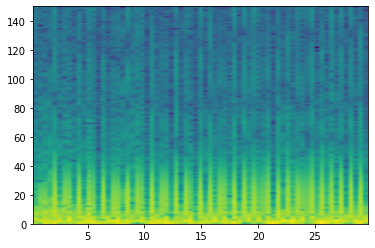

In [71]:
id=4
sig=ecg_train[id]
print(labels_train[id])
dedo=plt.specgram(sig, Fs=fs)


In [6]:
#folders to save the processed data
OUTPUT_DIR='C:/Users/hakim/Project AI/'
folder='ecg-2D'
train_folder='/train'
val_folder='/validation'
img_dir=os.path.join(OUTPUT_DIR,folder)
train_dir=img_dir+train_folder
val_dir=img_dir+val_folder

In [7]:
#Takes a timeseries dataset and converts it to a 2D Spectrogram and saves it in a train/validation folder under classType_name_idx
import os
import pylab
def process_Spectrogram(output,folder_Name,folder_type,data,labels,freq):
    if not os.path.exists(os.path.join(output, folder_Name)):
        os.mkdir(os.path.join(output, folder_Name))
    if not os.path.exists(folder_type):
        os.mkdir(folder_type)
    for idx, ecg_lead in enumerate(data):
        if len(labels)==0:
            target_dir=f'class_x'
        else:
            target_dir=f'class_{labels[idx]}'
        
        if not os.path.exists(folder_type+'/'+target_dir):
            os.mkdir(folder_type+'/'+target_dir)
        #save the spectrogram as an png with the name: classType_name_index
        save_dir=target_dir+f'_ecg_{idx}'
        save_dir=os.path.join(target_dir,save_dir)
        save_path=os.path.join(folder_type,save_dir)

        plt.specgram(ecg_lead, Fs=freq)
        plt.savefig(f'{save_path}.png')
        plt.close()

In [76]:
la=list()
len(la)
process_Spectrogram(OUTPUT_DIR,folder,val_dir,ecg_test,la,fs)

In [77]:
#for the training data
process_Spectrogram(OUTPUT_DIR,folder,train_dir,ecg_train,labels_train,fs)
#for the validation data
process_Spectrogram(OUTPUT_DIR,folder,val_dir,ecg_test,labels_test,fs)

In [8]:
#this just creates the datasets from the train and valitation folders
HEIGHT=256
WIDTH=256
BATCH_SIZE=32
CHANNELS=3

train_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=train_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)
val_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=val_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)

Found 16637 files belonging to 4 classes.
Found 2651 files belonging to 4 classes.


In [9]:
#here goes the actual model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
#CNN
cnn_model=tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Input(shape=(HEIGHT, WIDTH,CHANNELS)))
#first layer
cnn_model.add(tf.keras.layers.Conv2D(8, 4, strides=2, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#second layer
cnn_model.add(tf.keras.layers.Conv2D(13, 2, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#third layer
cnn_model.add(tf.keras.layers.Conv2D(13, 2, strides=1, padding='same',activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#now the dense layers
cnn_model.add(tf.keras.layers.Flatten())


cnn_model.add(tf.keras.layers.Dropout(0.5))
#first dense layer
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
#second dense layer
cnn_model.add(tf.keras.layers.Dense(512, activation='softmax'))
cnn_model.add(tf.keras.layers.BatchNormalization())

#last layer
cnn_model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [13]:
#compile model
opt=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
cnn_model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 8)       392       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 13)        429       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 13)        52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 13)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 13)        6

In [ ]:
# Train model for 10 epochs, capture the history
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

history = cnn_model.fit(train_data, epochs=100, validation_data=val_data, callbacks =[earlystopping])

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

Epoch 1/100
520/520 [==============================] - 72s 136ms/step - loss: 0.7639 - accuracy: 0.6538 - val_loss: 0.7968 - val_accuracy: 0.6337
Epoch 2/100
520/520 [==============================] - 68s 131ms/step - loss: 0.7292 - accuracy: 0.6723 - val_loss: 0.7792 - val_accuracy: 0.6477
Epoch 3/100
520/520 [==============================] - 71s 136ms/step - loss: 0.6934 - accuracy: 0.6846 - val_loss: 0.7315 - val_accuracy: 0.6741
Epoch 4/100
520/520 [==============================] - 73s 140ms/step - loss: 0.6713 - accuracy: 0.6987 - val_loss: 0.7070 - val_accuracy: 0.6888
Epoch 5/100
520/520 [==============================] - 72s 139ms/step - loss: 0.6438 - accuracy: 0.7152 - val_loss: 0.6648 - val_accuracy: 0.7084
Epoch 6/100
520/520 [==============================] - 69s 133ms/step - loss: 0.6122 - accuracy: 0.7287 - val_loss: 0.6816 - val_accuracy: 0.6994
Epoch 7/100
520/520 [==============================] - 72s 139ms/step - loss: 0.5931 - accuracy: 0.7426 - val_loss: 0.6181 -

Epoch 57/100
520/520 [==============================] - 69s 132ms/step - loss: 0.1157 - accuracy: 0.9573 - val_loss: 0.1731 - val_accuracy: 0.9374
Epoch 58/100
520/520 [==============================] - 70s 134ms/step - loss: 0.1179 - accuracy: 0.9574 - val_loss: 0.1766 - val_accuracy: 0.9427
Epoch 59/100
520/520 [==============================] - 71s 136ms/step - loss: 0.1153 - accuracy: 0.9579 - val_loss: 0.1105 - val_accuracy: 0.9642
Epoch 60/100
520/520 [==============================] - 78s 150ms/step - loss: 0.1103 - accuracy: 0.9610 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 61/100
520/520 [==============================] - 75s 145ms/step - loss: 0.1119 - accuracy: 0.9582 - val_loss: 0.1421 - val_accuracy: 0.9487
Epoch 62/100
520/520 [==============================] - 72s 138ms/step - loss: 0.1000 - accuracy: 0.9626 - val_loss: 0.1169 - val_accuracy: 0.9627
Epoch 63/100
520/520 [==============================] - 74s 142ms/step - loss: 0.1073 - accuracy: 0.9622 - val_loss: 0

In [ ]:
predict_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=pred_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)
classes = cnn_model.predict(predict_data)
#this sorts the predicted data and saves it in a tuple list
predictions=list()
for idx, ecg_lead in enumerate (classes):
    predictions.append(np.argmax(ecg_lead))
#this sorts the predicted data and saves it in a tuple list
predictions=list()
for idx, ecg_lead in enumerate (classes):
    predictions.append(np.argmax(ecg_lead))
#esto se engarga de guardar las predictions
labels_toTest=list()
for ecg in os.listdir(pred_dir+'/class_x'):
    ecg_idx=int(ecg.split("ecg_")[1].split(".")[0])
    ecg_class=predictions[ecg_idx]
    label2give="N"
    if int(ecg_class)==0:
        labels2give="N"
    elif int(ecg_class)==1:
        labels2give="A"
    elif int(ecg_class)==2:
        labels2give="O"
    else:
        labels2give="~"
    #esto es para el name
    labels_toTest.append((ecg.split("_",2)[-1].split('.')[0],labels2give))
#for true labels
labels_true=np.empty(len(predictions))
labels_names=list()
labels_toSave=list()
#this gets the labels of the training set
for fol in os.listdir(val_dir):
    for ecg in os.listdir(os.path.join(val_dir,fol)):
        #we iterate all the names of the validation data
        
        ecg_class=ecg.split('_',3)
        ecg_idx=ecg_class[3].split('.',1)
        ecg_idx=ecg_idx[0]
        ecg_class=ecg_class[1]
        labels_true[int(ecg_idx)]=int(ecg_class)
        label2give="N"
        if int(ecg_class)==0:
            labels2give="N"
        elif int(ecg_class)==1:
            labels2give="A"
        elif int(ecg_class)==2:
            labels2give="O"
        else:
            labels2give="~"
        #esto es para el name
        labels_toSave.append((ecg.split("_",2)[-1].split('.')[0],labels2give))
#save overall predictions
save_predictions(labels_toTest,pred_dir,"PREDICTIONS")
save_predictions(labels_toSave,pred_dir,"REFERENCE")
#plot score
score(pred_dir)

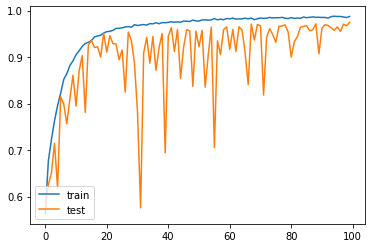

In [60]:
# accuracy and validation accuracy plot
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.legend(loc="lower left")
plt.savefig('result_paper_with_filter.pdf')

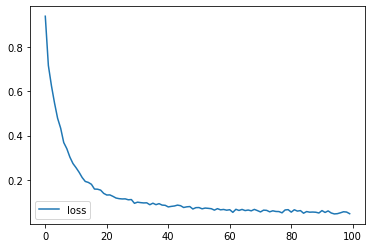

In [58]:
plt.plot(history.history['loss'], label='loss')
plt.legend(loc='lower left')

In [18]:
#Save the model
# serialize model to JSON
model_json = cnn_model.to_json()
model_name='model.json'
model_name=os.path.join(img_dir,model_name)
weights_name='model.h5'
weights_name=os.path.join(img_dir,weights_name)
with open(model_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5

cnn_model.save_weights(weights_name)
print("Saved model to disk")

Saved model to disk


In [19]:
#load the model
# load json and create model
json_file = open(model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_name)

In [20]:
#compile the model
loaded_model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
predict_dir=img_dir+'/predict'

In [10]:
predict_data=tf.keras.preprocessing.image_dataset_from_directory(batch_size=BATCH_SIZE, directory=predict_dir, color_mode='rgb',image_size=(HEIGHT,WIDTH),seed=0)
classes = cnn_model.predict(predict_data)

Found 1069 files belonging to 1 classes.


In [11]:
#this sorts the predicted data and saves it in a tuple list
predictions=list()
for idx, ecg_lead in enumerate (classes):
    predictions.append(np.argmax(ecg_lead))

In [51]:
from sklearn.metrics import f1_score
f1_score(labels_true, predictions,average='macro')
#ugh

0.24805566706811183

In [49]:
labels_true=np.empty(len(predictions))
#this gets the labels of the training set
for fol in os.listdir(val_dir):
    for ecg in os.listdir(os.path.join(val_dir,fol)):
        #we iterate all the names of the validation data
        ecg_class=ecg.split('_',3)
        ecg_idx=ecg_class[3].split('.',1)
        ecg_idx=ecg_idx[0]
        ecg_class=ecg_class[1]
        labels_true[int(ecg_idx)]=int(ecg_class)